In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import warnings
warnings.filterwarnings('ignore')

In [2]:
# date format: year-month-day
def slicing_formation(date1, date2):
    df = pd.read_csv('cleanest_data_ever.csv', index_col = 'Date')
    dta = df.loc[date1:date2]
    return(dta)
def slicing_trading(dta1, dta2):
    df = pd.read_csv('cleanest_data_ever.csv', index_col = 'Date')
    dta = df.loc[dta1 : dta2]
    return(dta)
def normalizing(data): # input: sliced dataset, output: normalized dataset
    df = pd.DataFrame(index = data.index, columns = data.columns)
    for i in df.columns:
        df[i][0] = 1
        for j in range(1, len(df)):
            df[i][j] = data[i][j] / data[i][0]
    return(df)
def ssd(col1, col2):
    s = (col1 - col2)**2
    ssd = s.sum()
    return(ssd)
def ssd_matrix(dta): # input normalized dataset
    matrix = pd.DataFrame(index = dta.columns, columns = dta.columns)
    for i in matrix.index:
        for j in matrix.columns:
            if i != j:
                matrix.loc[i,j] = ssd(dta[i], dta[j])
    return(matrix)
def min_values(matrix): # input: ssd matrix
    minimums = []
    for i in matrix.index:
        for j in matrix.columns:
            minimums.append(matrix.loc[i,j])
    minimums.remove(minimums[0])
    minimums = list(dict.fromkeys(minimums))
    minimums.sort()
    return(minimums)
def standard_deviation(col1,col2):
    series = col1 - col2
    std = stat.stdev(series)
    return(std)

In [3]:
def forming_pairs(date1, date2):
    dataframe = slicing_formation(date1, date2)
    norm_dataframe = normalizing(dataframe)
    coef_matrix = ssd_matrix(norm_dataframe)
    coef_list = min_values(coef_matrix)
    return(coef_matrix, coef_list)
def pair_tickers(coeff_matrix, coeff_list, x):
    pair_names = []
    for c in coeff_list:
        for i in coeff_matrix.index:
            for j in coeff_matrix.columns:
                if coeff_matrix.loc[i,j] == c:
                    names = [i,j]
                    pair_names.append(names)
    for i in pair_names:
        pair_names.remove([i[1], i[0]])
    return(pair_names[:x])
def pair_profit(profit1, profit2):
    profit = (profit1 + profit2) / 2
    return(profit)

In [4]:
def trading_df(pair1, pair2, date1, date2, date3, date4):
    dataframe = slicing_trading(date1, date2)
    dataframe_copy = dataframe.copy()
    norm_dataframe_copy = normalizing(dataframe_copy)
    norm_dataframe_copy = norm_dataframe_copy.reset_index()
    dataframe_trading = slicing_formation(date3, date4)
    norm_dataframe_trading = normalizing(dataframe_trading)
    pair_frame = norm_dataframe_copy[['Date', pair1, pair2]]
    stdev = standard_deviation(norm_dataframe_trading[pair1], norm_dataframe_trading[pair2])
    pair_frame['Signal'] = pd.Series(np.zeros(len(pair_frame)))
    first_pair = pd.DataFrame(pair_frame['Date'])
    first_pair['Signal'] = pd.Series(np.zeros(len(first_pair)))
    second_pair = pd.DataFrame(pair_frame['Date'])
    second_pair['Signal'] = pd.Series(np.zeros(len(second_pair)))
    pair_frame['Signal'][0] = 0
    first_pair['Signal'][0] = 0
    second_pair['Signal'][0] = 0
    for x in range(len(pair_frame)):
        if pair_frame[pair1][x] - pair_frame[pair2][x] > 2 * stdev:
            pair_frame['Signal'][x] = 1
            first_pair['Signal'][x] = 1
            second_pair['Signal'][x] = -1
        elif pair_frame[pair2][x] - pair_frame[pair1][x] > 2 * stdev:
            pair_frame['Signal'][x] = 1
            first_pair['Signal'][x] = -1
            second_pair['Signal'][x] = 1
        elif pair_frame[pair2][x] - pair_frame[pair1][x] == 0:
            pair_frame['Signal'][x] = 0
            first_pair['Signal'][x] = 0
            second_pair['Signal'][x] = 0
        elif (pair_frame[pair1][x - 1] - pair_frame[pair2][x - 1]) / (pair_frame[pair1][x] - pair_frame[pair2][x]) < 0:
            pair_frame['Signal'][x] = 0
            first_pair['Signal'][x] = 0
            second_pair['Signal'][x] = 0
        else:
            pair_frame['Signal'][x] = pair_frame['Signal'][x - 1]
            first_pair['Signal'][x] = first_pair['Signal'][x - 1]
            second_pair['Signal'][x] = second_pair['Signal'][x - 1]
    pair_frame['Position'] = pair_frame['Signal'].diff()
    first_pair['Position'] = first_pair['Signal'].diff()
    second_pair['Position'] = second_pair['Signal'].diff()
    close1 = dataframe[pair1]
    first_pair.index = first_pair['Date']
    first_pair['Close'] = close1
    first_pair.drop(labels = 'Date', axis = 1, inplace = True)
    first_pair = first_pair.reset_index()
    close2 = dataframe[pair2]
    second_pair.index = second_pair['Date']
    second_pair['Close'] = dataframe[pair2]
    second_pair.drop(labels = 'Date', axis = 1, inplace = True)
    second_pair = second_pair.reset_index()
    return(first_pair, second_pair)

In [9]:
# give dataframe with 'Signal', 'Position', 'Close', 'Date'
def trading(dta):
    dta['Total Assets'] = pd.Series(np.zeros(len(dta)))
    dta['Holding'] = pd.Series(np.zeros(len(dta)))
    dta['Employed Capital'] = pd.Series(np.zeros(len(dta)))
    dta['Shorted Capital'] = pd.Series(np.zeros(len(dta)))
    dta['Free Capital'] = pd.Series(np.zeros(len(dta)))
    dta['Total Assets'][0] = 10000
    dta['Holding'][0] = 0
    dta['Employed Capital'][0] = 0
    dta['Shorted Capital'][0] = 0
    dta['Free Capital'][0] = 10000
    shorted_cap = 0
    for x in range(1, len(dta)):
        if dta['Position'][x] == 1:
            if dta['Holding'][x - 1] == 0:
                dta['Holding'][x] = dta['Total Assets'][x - 1] // dta['Close'][x]
                dta['Employed Capital'][x] = dta['Holding'][x] * dta['Close'][x]
                dta['Free Capital'][x] = dta['Total Assets'][x -1] - dta['Employed Capital'][x]
                dta['Total Assets'][x] = dta['Free Capital'][x] + dta['Employed Capital'][x]
            else:
                dta['Employed Capital'][x] = dta['Employed Capital'][x - 1]
                profit_loss = (dta['Holding'][x - 1] * dta['Close'][x]) - shorted_cap
                dta['Total Assets'][x] = dta['Free Capital'][x - 1] + dta['Employed Capital'][x] + profit_loss
                dta['Free Capital'][x] = dta['Total Assets'][x]
                dta['Holding'][x] = 0
                dta['Shorted Capital'][x] = 0
#                 print(profit_loss)
        elif dta['Position'][x] == -1:
            if dta['Holding'][x - 1] == 0:
                dta['Holding'][x] = -(dta['Total Assets'][x - 1] // dta['Close'][x])
                dta['Employed Capital'][x] = dta['Employed Capital'][x - 1]
                dta['Free Capital'][x] = dta['Free Capital'][x - 1]
                shorted_cap = dta['Holding'][x] * dta['Close'][x]
#                 print(shorted_cap)
                dta['Shorted Capital'][x] = dta['Holding'][x] * dta['Close'][x]
                dta['Total Assets'][x] = dta['Free Capital'][x] + dta['Employed Capital'][x]
            else:
                dta['Shorted Capital'][x] = dta['Shorted Capital'][x - 1]
                dta['Free Capital'][x] = dta['Free Capital'][x - 1]
                dta['Employed Capital'][x] = 0
                dta['Total Assets'][x] = dta['Free Capital'][x] + dta['Holding'][x - 1] * dta['Close'][x]
                
        else:
            dta['Holding'][x] = dta['Holding'][x - 1]
            if dta['Holding'][x] > 0:
                dta['Shorted Capital'][x] = dta['Shorted Capital'][x - 1]
                dta['Free Capital'][x] = dta['Free Capital'][x - 1]
                dta['Employed Capital'][x] = dta['Holding'][x] * dta['Close'][x]
                dta['Total Assets'][x] = dta['Free Capital'][x] + dta['Employed Capital'][x]
            elif dta['Holding'][x] < 0:
                dta['Employed Capital'][x] = dta['Employed Capital'][x - 1]
                dta['Free Capital'][x] = dta['Free Capital'][x - 1]
                dta['Shorted Capital'][x] = dta['Holding'][x] * dta['Close'][x]
                dta['Total Assets'][x] = dta['Free Capital'][x] + dta['Employed Capital'][x] 
            else:
                dta['Free Capital'][x] = dta['Free Capital'][x - 1]
                dta['Employed Capital'][x] = dta['Employed Capital'][x - 1]
                dta['Shorted Capital'][x] = dta['Shorted Capital'][x - 1]
                dta['Total Assets'][x] = dta['Total Assets'][x - 1]
    if dta['Holding'][len(dta) - 1] > 0:
        profit = (dta['Total Assets'][len(dta) - 1] / dta['Total Assets'][0] - 1) * 100
    elif dta['Holding'][len(dta) - 1] < 0:
        profit1 = dta['Shorted Capital'][len(dta) - 1] - shorted_cap
        profit = ((profit1 + dta['Total Assets'][len(dta) - 1]) / dta['Total Assets'][0] - 1) * 100
    else:
        profit = (dta['Total Assets'][len(dta) - 1] / dta['Total Assets'][0] - 1) * 100
    return(profit)

In [10]:
def distance_method(date1, date2, date3, date4, x): # formation period: date1, date2. trading period: date3, date4
    coeff_matrix, coeff_list = forming_pairs(date1, date2)
    pairs = pair_tickers(coeff_matrix, coeff_list, x)
    print(pairs)
    period_return = []
    for i in pairs:
        pair1 = i[0]
        pair2 = i[1]
        df_pair1, df_pair2 = trading_df(pair1, pair2, date3, date4, date1, date2)
        profit_1 = trading(df_pair1)
        profit_2 = trading(df_pair2)
        pair_return = pair_profit(profit_1, profit_2)
        period_return.append(pair_return)
    pairs_and_returns = dict(zip(period_return, pairs)) 
    return(period_return)
    return(pairs)


In [11]:
def average(sequence): # input a list
    sum_ = sum(sequence)
    mean = sum_ / len(sequence)
    return(mean)

In [12]:
path = 'dates.csv' # monthly rotation
dates = pd.read_csv(path)


In [13]:
returns = pd.DataFrame(index = dates.index, columns = ['returns','date1','date2','date3','date4'])
for i in dates.index[82:83]:
    date1 = dates.loc[i, 'date1']
    date2 = dates.loc[i, 'date2']
    date3 = dates.loc[i, 'date3']
    date4 = dates.loc[i, 'date4']
    seq = distance_method(date1, date2, date3, date4, 20)
    value = average(seq)
    returns.loc[i, 'returns'] = value
    returns.loc[i, 'date1'] = dates.loc[i, 'date1']
    returns.loc[i, 'date2'] = dates.loc[i, 'date2']
    returns.loc[i, 'date3'] = dates.loc[i, 'date3']
    returns.loc[i, 'date4'] = dates.loc[i, 'date4']
    
    

[['AALB.AS', 'AGS.BR'], ['SIP.BR', 'VASTN.AS'], ['BEFB.BR', 'NSI.AS'], ['ACOMO.AS', 'GBLB.BR'], ['BOKA.AS', 'VASTN.AS'], ['BEFB.BR', 'KIN.BR'], ['CFEB.BR', 'TESB.BR'], ['BOKA.AS', 'SIP.BR'], ['BEFB.BR', 'GBLB.BR'], ['BOKA.AS', 'ROOD.AS'], ['BEFB.BR', 'SOF.BR'], ['CFEB.BR', 'SOLB.BR'], ['AGS.BR', 'ICT.AS'], ['AALB.AS', 'ICT.AS'], ['BEFB.BR', 'EVS.BR'], ['BEFB.BR', 'VPK.AS'], ['CFEB.BR', 'INGA.AS'], ['CFEB.BR', 'HAL.AS'], ['CFEB.BR', 'ROOD.AS'], ['AALB.AS', 'SOF.BR']]


In [14]:
returns.to_excel('top_20_pairs_returns_DM4.xlsx', index = True)

In [42]:
distance_method(dates.loc[0,'date1'],dates.loc[0,'date2'],dates.loc[0,'date3'],dates.loc[0,'date4'],20)

[['HAL.AS', 'SOF.BR'], ['TUB.BR', 'UCB.BR'], ['EVS.BR', 'SOF.BR'], ['AALB.AS', 'RAND.AS'], ['EVS.BR', 'HAL.AS'], ['AALB.AS', 'TESB.BR'], ['UCB.BR', 'VPK.AS'], ['SOF.BR', 'WKL.AS'], ['ELI.BR', 'HAL.AS'], ['BBED.AS', 'CFEB.BR'], ['AALB.AS', 'GBLB.BR'], ['BEFB.BR', 'RDSA.AS'], ['BOKA.AS', 'WKL.AS'], ['CFEB.BR', 'SIP.BR'], ['BOKA.AS', 'EXM.BR'], ['BBED.AS', 'SIP.BR'], ['AGFB.BR', 'TWEKA.AS'], ['BBED.AS', 'VAN.BR'], ['BOKA.AS', 'ORDI.AS'], ['CFEB.BR', 'RAND.AS'], ['AGFB.BR', 'ROOD.AS'], ['ACOMO.AS', 'VPK.AS'], ['ACOMO.AS', 'HEIA.AS'], ['AALB.AS', 'DSM.AS'], ['AGFB.BR', 'SIP.BR'], ['BBED.AS', 'FUR.AS'], ['AALB.AS', 'HAL.AS'], ['CFEB.BR', 'REC.BR'], ['BOKA.AS', 'HAL.AS'], ['BBED.AS', 'ROOD.AS'], ['ACOMO.AS', 'NEDAP.AS'], ['ACOMO.AS', 'UMI.BR'], ['AGFB.BR', 'REC.BR'], ['BBED.AS', 'RAND.AS'], ['BOKA.AS', 'SOF.BR'], ['AGFB.BR', 'VAN.BR'], ['AALB.AS', 'ACKB.BR'], ['CFEB.BR', 'TESB.BR'], ['BOKA.AS', 'DIE.BR'], ['BOKA.AS', 'EVS.BR'], ['BBED.AS', 'REC.BR'], ['AALB.AS', 'REC.BR'], ['BEKB.BR', 'HEIJM.

[0.0,
 2.8671246950000007,
 6.987454770000001,
 -6.704301839999987,
 6.704462224999997,
 8.132897699999987,
 -0.7197641249999993,
 -4.541798590000002,
 0.0,
 -5.320448869999988,
 -0.022925820000024633,
 -5.590001665,
 6.1141059800000015,
 1.9831249399999917,
 -2.1361266049999887,
 4.300631160000002,
 -7.530974999999995,
 0.0,
 8.040448485000008,
 -5.753731484999985]

In [22]:
print(returns['returns'].mean())

-10.930057318430105


In [39]:
returns.to_csv('returns_monthly.csv', index = True)

<AxesSubplot:>

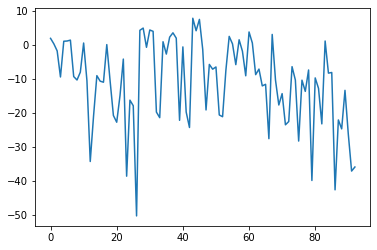

In [23]:
returns['returns'].plot()

In [8]:
weekly = pd.read_csv('weekly_dates.csv')

In [9]:
returns1 = pd.DataFrame(index = weekly.index, columns = ['returns','date1','date2','date3','date4'])
for i in weekly.index:
    date1 = weekly.loc[i, 'date1']
    date2 = weekly.loc[i, 'date2']
    date3 = weekly.loc[i, 'date3']
    date4 = weekly.loc[i, 'date4']
    seq = distance_method(date1, date2, date3, date4)
    value = average(seq)
    returns1.loc[i, 'returns'] = value
    returns1.loc[i, 'date1'] = weekly.loc[i, 'date1']
    returns1.loc[i, 'date2'] = weekly.loc[i, 'date2']
    returns1.loc[i, 'date3'] = weekly.loc[i, 'date3']
    returns1.loc[i, 'date4'] = weekly.loc[i, 'date4']

IndexError: index 0 is out of bounds for axis 0 with size 0

In [65]:
distance_method(dates.loc[82,'date1'], dates.loc[82, 'date2'], dates.loc[82, 'date3'], dates.loc[82, 'date4'], 20) 

[['AALB.AS', 'AGS.BR'], ['SIP.BR', 'VASTN.AS'], ['BEFB.BR', 'NSI.AS'], ['ACOMO.AS', 'GBLB.BR'], ['BOKA.AS', 'VASTN.AS'], ['BEFB.BR', 'KIN.BR'], ['CFEB.BR', 'TESB.BR'], ['BOKA.AS', 'SIP.BR'], ['BEFB.BR', 'GBLB.BR'], ['BOKA.AS', 'ROOD.AS'], ['BEFB.BR', 'SOF.BR'], ['CFEB.BR', 'SOLB.BR'], ['AGS.BR', 'ICT.AS'], ['AALB.AS', 'ICT.AS'], ['BEFB.BR', 'EVS.BR'], ['BEFB.BR', 'VPK.AS'], ['CFEB.BR', 'INGA.AS'], ['CFEB.BR', 'HAL.AS'], ['CFEB.BR', 'ROOD.AS'], ['AALB.AS', 'SOF.BR']]


UnboundLocalError: local variable 'shorted_cap' referenced before assignment